## Goals of Project

1. Automate the process of writing notes in a natural language format of each tract in a BLM Oil and Gas Lease Sale

2.  Create visualizaitons tract by tract for CEO depicting permitting, new production, and leasing activity within a given radius

3.  Create a predictive model to estimate the purchase price based on historical activity, production, permits, and commodity prices

## Goals of Notebook

This notebook will create machine learning models to predict bonus prices in upcoming lease sale



In [1]:
import pandas as pd
import geopandas as gp
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import shapely
import math
import datetime as dt
import pdb

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
#had to add GDAL_DATA variable to system variables and set value to the folder of gdal in C:\Users\mishaun\AppData\Local\Continuum\anaconda3\Library\share\gdal on my work computer
'GDAL_DATA' in os.environ

False

In [2]:
%run GlobalFuncts_n_Vars.py

In [3]:
store -r MLPredandResponseCols

***
# Machine Learning and Price Projections Section
***

# Training a model with Sklearn

### Reading in Cleaned Data


In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
#reading in cleaned leases from file for easy retrieval
cleanedLeases = pd.read_excel("Output Data/Training Leases Activity Data/Cleaned Training Leases.xlsx")

In [6]:
#resetting index to original index prior to exporting to file
cleanedLeases.head()
cleanedLeases.set_index("LeaseIndex", inplace = True)

cleanedLeases.head()

,LeaseIndex,Record Date,Record Number,Bonus,Section,Township,Range,geometry,buffers,Total Permits,...,Avg First 6 Mo Gas,Qi Oil,Qi Gas,6 Mo Oil Revenue $,6 Mo Gas Rev $,Oil Price,Gas Price,TWSHP,Record Year,Log Bonus
0,57,2019-12-11,WYW189586,1527,3,39,73,POINT (450547.6131938574 4803344.147960225),"POLYGON ((455375.6331938574 4803344.147960225,...",9,...,46031.020833,3210.612245,9631.836735,9.161291e+05,102188.866250,59.88,2.22,39 73,2019,7.331060
1,58,2019-12-11,WYW189586,1527,9,39,73,POINT (448886.0374564391 4801760.549607107),"POLYGON ((453714.0574564391 4801760.549607107,...",14,...,38966.214286,3319.473684,8427.894737,8.790245e+05,86504.995714,59.88,2.22,39 73,2019,7.331060
2,59,2019-12-11,WYW189590,302,27,39,73,POINT (450464.34694615 4796947.371161564),"POLYGON ((455292.36694615 4796947.371161564, 4...",10,...,49281.540541,3801.315789,10975.263158,1.064804e+06,109405.020000,59.88,2.22,39 73,2019,5.710427
3,60,2019-12-11,WYW189596,1535,32,40,73,POINT (447329.5662888384 4804957.255790628),"POLYGON ((452157.5862888384 4804957.255790628,...",6,...,33128.175000,2092.325581,6826.046512,5.377658e+05,73544.548500,59.88,2.22,40 73,2019,7.336286
4,61,2019-12-11,WYW189593,752,28,40,73,POINT (448968.4909649936 4806538.52595432),"POLYGON ((453796.5109649936 4806538.52595432, ...",6,...,20281.240000,1899.230769,4250.769231,4.755215e+05,45024.352800,59.88,2.22,40 73,2019,6.622736


,Record Date,Record Number,Bonus,Section,Township,Range,geometry,buffers,Total Permits,Total Wells,...,Avg First 6 Mo Gas,Qi Oil,Qi Gas,6 Mo Oil Revenue $,6 Mo Gas Rev $,Oil Price,Gas Price,TWSHP,Record Year,Log Bonus
LeaseIndex,,,,,,,,,,,,,,,,,,,,,
57,2019-12-11,WYW189586,1527,3,39,73,POINT (450547.6131938574 4803344.147960225),"POLYGON ((455375.6331938574 4803344.147960225,...",9,49,...,46031.020833,3210.612245,9631.836735,9.161291e+05,102188.866250,59.88,2.22,39 73,2019,7.331060
58,2019-12-11,WYW189586,1527,9,39,73,POINT (448886.0374564391 4801760.549607107),"POLYGON ((453714.0574564391 4801760.549607107,...",14,57,...,38966.214286,3319.473684,8427.894737,8.790245e+05,86504.995714,59.88,2.22,39 73,2019,7.331060
59,2019-12-11,WYW189590,302,27,39,73,POINT (450464.34694615 4796947.371161564),"POLYGON ((455292.36694615 4796947.371161564, 4...",10,38,...,49281.540541,3801.315789,10975.263158,1.064804e+06,109405.020000,59.88,2.22,39 73,2019,5.710427
60,2019-12-11,WYW189596,1535,32,40,73,POINT (447329.5662888384 4804957.255790628),"POLYGON ((452157.5862888384 4804957.255790628,...",6,43,...,33128.175000,2092.325581,6826.046512,5.377658e+05,73544.548500,59.88,2.22,40 73,2019,7.336286
61,2019-12-11,WYW189593,752,28,40,73,POINT (448968.4909649936 4806538.52595432),"POLYGON ((453796.5109649936 4806538.52595432, ...",6,26,...,20281.240000,1899.230769,4250.769231,4.755215e+05,45024.352800,59.88,2.22,40 73,2019,6.622736


### Standardizing/Scaling inputs

In [7]:
#setting columns of dataframe that will be features or independent variables
inputs = cleanedLeases[["Total Permits",'6 Mo Oil Revenue $',"Total Wells", '6 Mo Gas Rev $']]
target = cleanedLeases["Log Bonus"]

scaler = StandardScaler()
scaler.fit(inputs)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [8]:
inputs_scaled = scaler.transform(inputs)

### Variance inflation factor

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# To make this as easy as possible to use, we declare a variable where we put
# all features where we want to check for multicollinearity

#create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(inputs.values, i) for i in range(inputs.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = inputs.columns

In [10]:
vif

,VIF,Features
0,1.604676,Total Permits
1,2.629100,6 Mo Oil Revenue $
2,1.590175,Total Wells
3,2.217620,6 Mo Gas Rev $


### Splitting training and testing data - Fitting multilinear regression

In [11]:
# Import the module for the split
from sklearn.model_selection import train_test_split

# Split the variables with an 80-20 split and some random state
# To have the same split as mine, use random_state = 365
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, target, test_size=0.15, random_state = 10)

In [12]:
#instantiating linear model
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Retrieving Predictions from X train features

In [13]:
#predicting bonuses based on training data
y_pred = reg.predict(x_train)

Text(0.5, 1.0, 'predicted bonus vs acutal bonus')

Text(0, 0.5, 'Prediced Log Bonus')

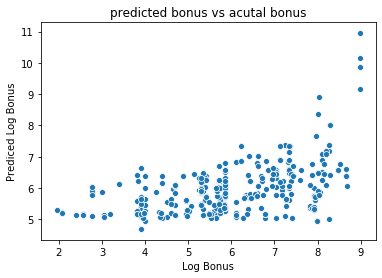

In [14]:
sns.scatterplot(y_train, y_pred)
plt.title("predicted bonus vs acutal bonus")
plt.ylabel("Prediced Log Bonus")


### Model Parameters

In [15]:
reg.coef_

inputs.columns

weights_Table = pd.DataFrame(data = reg.coef_, index = inputs.columns, columns = ["Weights"])

array([ 0.48504832,  0.39329113,  0.41489969, -0.15674212])

Index(['Total Permits', '6 Mo Oil Revenue $', 'Total Wells', '6 Mo Gas Rev $'], dtype='object')

In [16]:
weights_Table
print("Y intercept " + str(reg.intercept_))

,Weights
Total Permits,0.485048
6 Mo Oil Revenue $,0.393291
Total Wells,0.414900
6 Mo Gas Rev $,-0.156742


Y intercept 5.961871600154061


### Model Results and Predictions

In [17]:
def modelPerformance(actual, predictions):
    mae = metrics.mean_absolute_error(actual,predictions)
    var = metrics.explained_variance_score(actual, predictions)
    r2 = metrics.r2_score(actual, predictions)
    
    print("Mean Absolute Error: {} \nVariance Explained: {} \nR2 Score: {}".format(mae,var,r2))

In [18]:
y_pred_Bonus = np.exp(y_pred)

In [19]:
from sklearn import metrics
results = pd.DataFrame()

results["Bonus"] = np.exp(y_train)

results["Predicted"] = y_pred_Bonus

results["Perc Error"] = ((results["Predicted"] - results["Bonus"])/results["Bonus"]) * 100

In [20]:
results["Perc Error"].apply(lambda x: abs(x)).mean()
results["Perc Error"].mean()

195.4978382371477

138.9664911195031

In [21]:
metrics.mean_absolute_error(y_pred_Bonus, np.exp(y_train))

886.5214100274991

In [22]:
results

,Bonus,Predicted,Perc Error
LeaseIndex,,,
2505,55.0,589.983141,972.696620
2502,2750.0,321.279975,-88.317092
2704,350.0,371.920640,6.263040
3072,50.0,163.093619,226.187239
2356,1500.0,934.645823,-37.690278
2507,2800.0,278.794616,-90.043049
1858,451.0,920.832631,104.175750
3079,300.0,250.464652,-16.511783
3255,13.0,172.068883,1223.606789


### Merging Full Train Leases Dataframe with Model Predicted Information

In [23]:
#joining cleanedLeases information with index of predicted and training bonuses
resultsConcat = pd.concat([cleanedLeases, results], axis = 1, join="inner")

#rounding results to clean up dataframe
resultsConcat = resultsConcat.round(decimals = 0)

In [24]:
resultsConcat.head(3)
resultsConcat.columns

,Record Date,Record Number,Bonus,Section,Township,Range,geometry,buffers,Total Permits,Total Wells,...,6 Mo Oil Revenue $,6 Mo Gas Rev $,Oil Price,Gas Price,TWSHP,Record Year,Log Bonus,Bonus,Predicted,Perc Error
LeaseIndex,,,,,,,,,,,,,,,,,,,,,
57,2019-12-11,WYW189586,1527,3,39,73,POINT (450547.6131938574 4803344.147960225),"POLYGON ((455375.6331938574 4803344.147960225,...",9,49,...,916129.0,102189.0,60.0,2.0,39 73,2019,7.0,1527.0,978.0,-36.0
59,2019-12-11,WYW189590,302,27,39,73,POINT (450464.34694615 4796947.371161564),"POLYGON ((455292.36694615 4796947.371161564, 4...",10,38,...,1064804.0,109405.0,60.0,2.0,39 73,2019,6.0,302.0,803.0,166.0
60,2019-12-11,WYW189596,1535,32,40,73,POINT (447329.5662888384 4804957.255790628),"POLYGON ((452157.5862888384 4804957.255790628,...",6,43,...,537766.0,73545.0,60.0,2.0,40 73,2019,7.0,1535.0,656.0,-57.0


Index(['Record Date', 'Record Number', 'Bonus', 'Section', 'Township', 'Range',
       'geometry', 'buffers', 'Total Permits', 'Total Wells',
       'Avg First 6 Mo Oil', 'Avg First 6 Mo Gas', 'Qi Oil', 'Qi Gas',
       '6 Mo Oil Revenue $', '6 Mo Gas Rev $', 'Oil Price', 'Gas Price',
       'TWSHP', 'Record Year', 'Log Bonus', 'Bonus', 'Predicted',
       'Perc Error'],
      dtype='object')

In [25]:
#counting how many leases were over predicted by over 500%
len(results)
resultsConcat[resultsConcat["Perc Error"] > 500].count()

371

Record Date           29
Record Number         29
Bonus                 29
Section               29
Township              29
Range                 29
geometry              29
buffers               29
Total Permits         29
Total Wells           29
Avg First 6 Mo Oil    29
Avg First 6 Mo Gas    29
Qi Oil                29
Qi Gas                29
6 Mo Oil Revenue $    29
6 Mo Gas Rev $        29
Oil Price             29
Gas Price             29
TWSHP                 29
Record Year           29
Log Bonus             29
Bonus                 29
Predicted             29
Perc Error            29
dtype: int64

### Univariate Distrubtion of Percent Error

<Figure size 720x288 with 0 Axes>

Text(0.5, 1.0, 'Distribution of Percent Error')

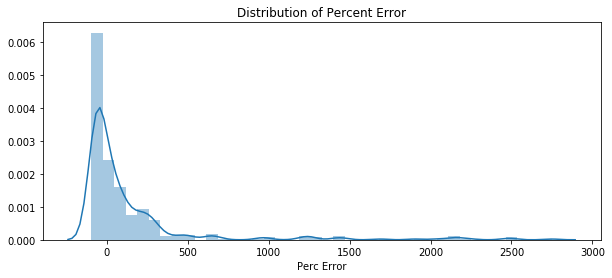

In [26]:
#looking at the distrubtion of our error

plt.figure(figsize=(10,4))
sns.distplot(resultsConcat["Perc Error"], bins = 40)
plt.title("Distribution of Percent Error")


In [27]:
resultsConcat["Perc Error"].quantile(.80)

207.0

* 80% of the training data has an error of less than 184% 
* Considering the volatility of bonus prices this is not a huge surprise

### Scatter Plot Showing Predicted vs Actual Bonus Prices - Lease by Lease

Text(0.5, 1.0, 'Actual Bonus (Green) vs Predicted Bonus (Red)')

Text(0.5, 0, 'Lease Index')

Text(0, 0.5, '$/acre')

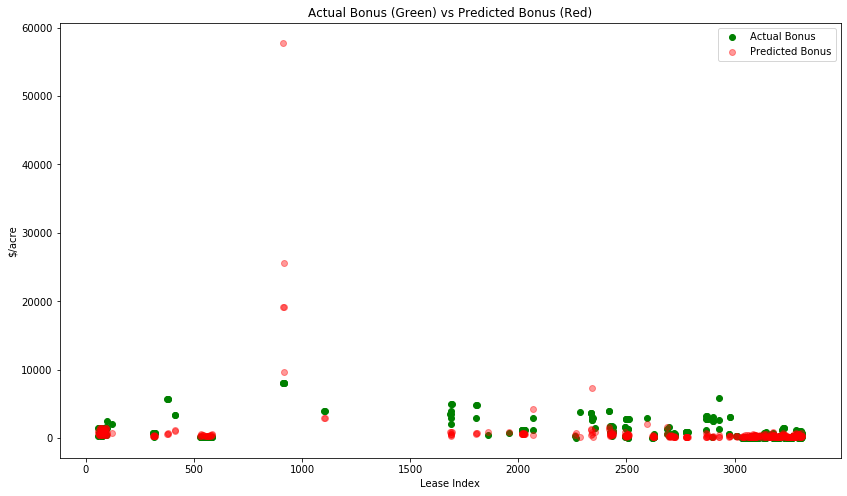

In [28]:
#scatter plot to overlay lease by lease, actual bonus vs predicted bonus
fig, ax1 = plt.subplots(1, figsize = (14,8))
ax1.scatter(resultsConcat.index, resultsConcat.iloc[:,2], c = 'g', label = "Actual Bonus")
ax1.scatter(resultsConcat.index, resultsConcat["Predicted"], c = 'r', alpha = .4, label = "Predicted Bonus")
ax1.set_title("Actual Bonus (Green) vs Predicted Bonus (Red)")
ax1.set_xlabel("Lease Index")
ax1.set_ylabel("$/acre")
ax1.legend()

#### * **We see that the model generally underestimates values** 

In [29]:
resultsConcat.describe().T

,count,mean,std,min,25%,50%,75%,max
Bonus,371.0,990.654987,1417.418897,7.0,147.5,350.0,1201.0,8004.0
Section,371.0,18.760108,10.633660,1.0,9.0,19.0,28.0,36.0
Township,371.0,38.226415,1.071726,37.0,37.0,38.0,39.0,40.0
Range,371.0,72.110512,1.008704,70.0,71.5,72.0,73.0,74.0
Total Permits,371.0,6.150943,13.323780,0.0,0.0,1.0,7.0,124.0
Total Wells,371.0,17.773585,15.641506,1.0,3.0,13.0,29.0,55.0
Avg First 6 Mo Oil,371.0,10011.646900,11160.853019,0.0,3090.0,7282.0,12277.0,82446.0
Avg First 6 Mo Gas,371.0,15269.902965,25446.200952,0.0,1754.0,3628.0,20281.0,197850.0
Qi Oil,371.0,2619.509434,3084.854426,0.0,795.0,1790.0,3104.0,26010.0
Qi Gas,371.0,4281.234501,7689.151727,0.0,314.0,816.0,4620.0,40644.0


* model is predicting one huge error of 2802% and 45k/acre - throwing off avg percent error

In [30]:
resultsConcat.head(3)

,Record Date,Record Number,Bonus,Section,Township,Range,geometry,buffers,Total Permits,Total Wells,...,6 Mo Oil Revenue $,6 Mo Gas Rev $,Oil Price,Gas Price,TWSHP,Record Year,Log Bonus,Bonus,Predicted,Perc Error
LeaseIndex,,,,,,,,,,,,,,,,,,,,,
57,2019-12-11,WYW189586,1527,3,39,73,POINT (450547.6131938574 4803344.147960225),"POLYGON ((455375.6331938574 4803344.147960225,...",9,49,...,916129.0,102189.0,60.0,2.0,39 73,2019,7.0,1527.0,978.0,-36.0
59,2019-12-11,WYW189590,302,27,39,73,POINT (450464.34694615 4796947.371161564),"POLYGON ((455292.36694615 4796947.371161564, 4...",10,38,...,1064804.0,109405.0,60.0,2.0,39 73,2019,6.0,302.0,803.0,166.0
60,2019-12-11,WYW189596,1535,32,40,73,POINT (447329.5662888384 4804957.255790628),"POLYGON ((452157.5862888384 4804957.255790628,...",6,43,...,537766.0,73545.0,60.0,2.0,40 73,2019,7.0,1535.0,656.0,-57.0


In [31]:
#looking at what the training parameters were for the abnormal prediciton of 40k/acre
resultsConcat.loc[resultsConcat["Predicted"]>30000]


,Record Date,Record Number,Bonus,Section,Township,Range,geometry,buffers,Total Permits,Total Wells,...,6 Mo Oil Revenue $,6 Mo Gas Rev $,Oil Price,Gas Price,TWSHP,Record Year,Log Bonus,Bonus,Predicted,Perc Error
LeaseIndex,,,,,,,,,,,,,,,,,,,,,
913,2018-09-18,WYW187435,8004,17,39,72,POINT (456987.9394583493 4800362.80558945),"POLYGON ((461815.9594583493 4800362.80558945, ...",124,19,...,4617697.0,593549.0,70.0,3.0,39 72,2018,9.0,8004.0,57728.0,621.0


* good news is that this abnormal prediciton occured on highest bonus in training data - leads to indication we need to tune the model with potential isotonic regression

### Honing in on Percent Error on Bonus Price

<Figure size 1080x504 with 0 Axes>

Text(0.5, 1.0, '% Error vs. Bonus')

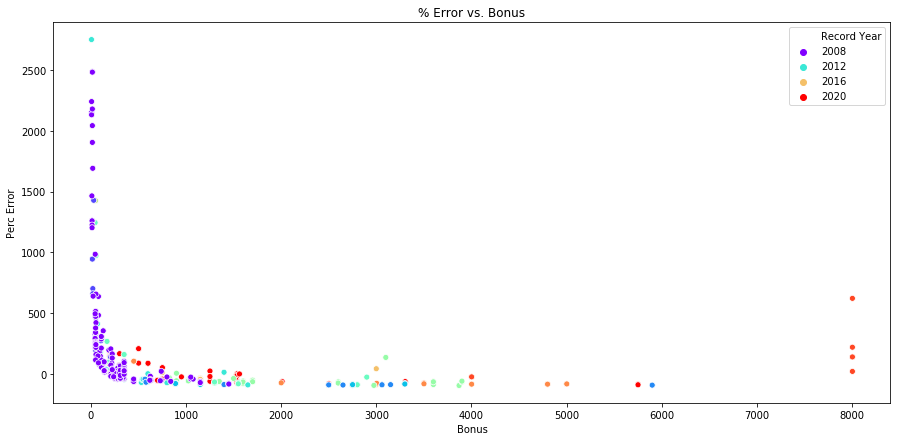

In [32]:
plt.figure(figsize=(15,7))
#bonus column is duplicated - thus - using .iloc[:,2]
sns.scatterplot(resultsConcat.iloc[:,2], resultsConcat["Perc Error"], hue = resultsConcat["Record Year"], palette = "rainbow")
plt.title("% Error vs. Bonus")

* Large errors occur at bonuses less than $500
* Need to determine how characteristics of learning features appear to look like at small bonus prices
* Also, bonuses of leases in 2008 appear to be causing the most errors - maybe we can remove 2008 lease prices for training the model

In [33]:
resultsConcat['Perc Error'].quantile(.90)
resultsConcat["Bonus"].quantile(.01)

341.0

Bonus    10.1
Bonus    10.1
Name: 0.01, dtype: float64

Text(0.5, 1.0, 'Zooming on Lease Bonus with Error \n% Error vs. Bonus\n Predicted (black) vs. Actual (rainbow)')

(0, 500)

(0, 4000)

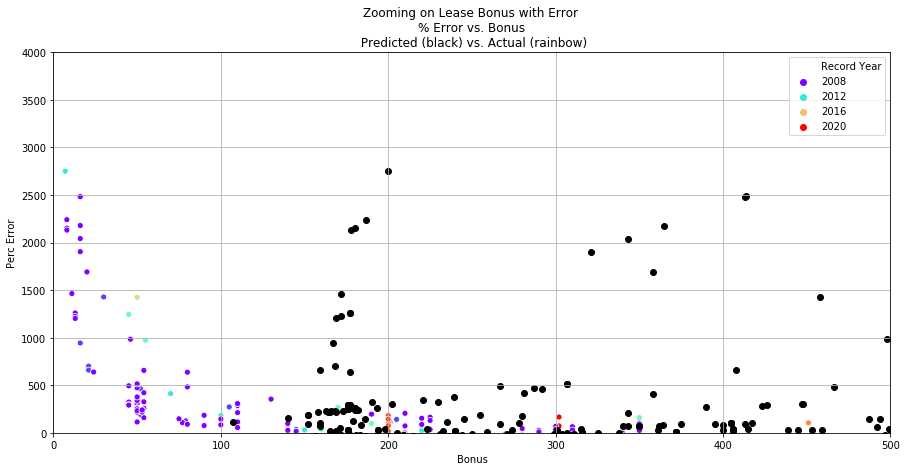

In [34]:
#Zooming in on smaller bonuses where large errors occured
fig, ax = plt.subplots(1,1, figsize=(15,7))
#bonus column is duplicated - thus - using .iloc[:,2]
sns.scatterplot(resultsConcat.iloc[:,2], resultsConcat["Perc Error"], hue = resultsConcat["Record Year"], palette = "rainbow", ax = ax)
ax.set_title("Zooming on Lease Bonus with Error \n% Error vs. Bonus\n Predicted (black) vs. Actual (rainbow)")
ax.set_xlim([0,500])
ax.set_ylim([0,4000])

ax.scatter(resultsConcat["Predicted"], resultsConcat["Perc Error"], c = "k")
plt.grid(True)

* Large errors occur under $50/acre  - multiple linear regression over entire data range may not work - may have to split up data or perform isotonic regression

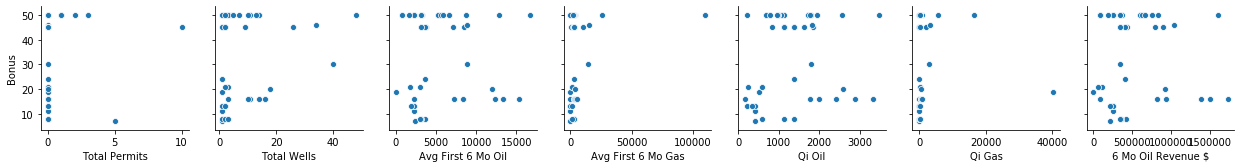

In [35]:

a = sns.pairplot(cleanedLeases[cleanedLeases["Bonus"]<51], y_vars="Bonus", x_vars = learningCols[0:7])


* we see that there is a lot high variance on bonus price when there is 0 to minimal magnitude on the learning features

* we may need to do isotonic regressions at different intervals of each learning feature to better fit low bonus priced tracts

In [36]:
cleanedLeases[cleanedLeases["Bonus"]<51][MLPredandResponseCols].describe().T

,count,mean,std,min,25%,50%,75%,max
Bonus,53.0,35.490566,16.842737,7.00,16.000000,45.000000,50.000000,5.000000e+01
Total Permits,53.0,0.490566,1.624602,0.00,0.000000,0.000000,0.000000,1.000000e+01
Total Wells,53.0,7.490566,10.039581,1.00,2.000000,3.000000,11.000000,4.800000e+01
Avg First 6 Mo Oil,53.0,4967.529563,3882.806804,43.00,2322.333333,3089.500000,6670.000000,1.675564e+04
Avg First 6 Mo Gas,53.0,5113.841056,15252.805282,0.00,952.666667,2228.666667,3112.500000,1.095447e+05
Qi Oil,53.0,1258.824997,793.725356,160.00,690.000000,1125.000000,1770.000000,3.478125e+03
Qi Gas,53.0,1555.572997,5938.667088,0.00,75.000000,304.285714,372.000000,4.041000e+04
6 Mo Oil Revenue $,53.0,502350.609956,394242.739464,4047.59,258708.840000,347815.910000,663452.703333,1.727292e+06
6 Mo Gas Rev $,53.0,43221.518428,129495.036059,0.00,6459.080000,21378.848333,31685.250000,9.355120e+05
Oil Price,53.0,102.687170,23.219402,39.09,112.580000,112.580000,112.580000,1.166700e+02


## Decision Tree Model

In [37]:
#importing libraries for creating decision tree model
import math                                               # basic calculations like square root
from sklearn import tree                                  # tree program from scikit learn (package for machine learning)
from sklearn.tree import _tree                            # for accessing tree information
from sklearn import metrics                               # measures to check our models
from sklearn.model_selection import cross_val_score       # cross validation methods
from sklearn.tree import export_graphviz  

### Sample Decision Tree - No Scaled or Transformed Data
* Helps to interpret decision tree flow chart

In [38]:
#establishing initial simple model
treeModel = tree.DecisionTreeRegressor(criterion='mae', min_samples_leaf=4, max_depth = 4)
treeModel = treeModel.fit(scaler.inverse_transform(x_train), np.exp(y_train))

### Visualizing Decision Tree with Packages

/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


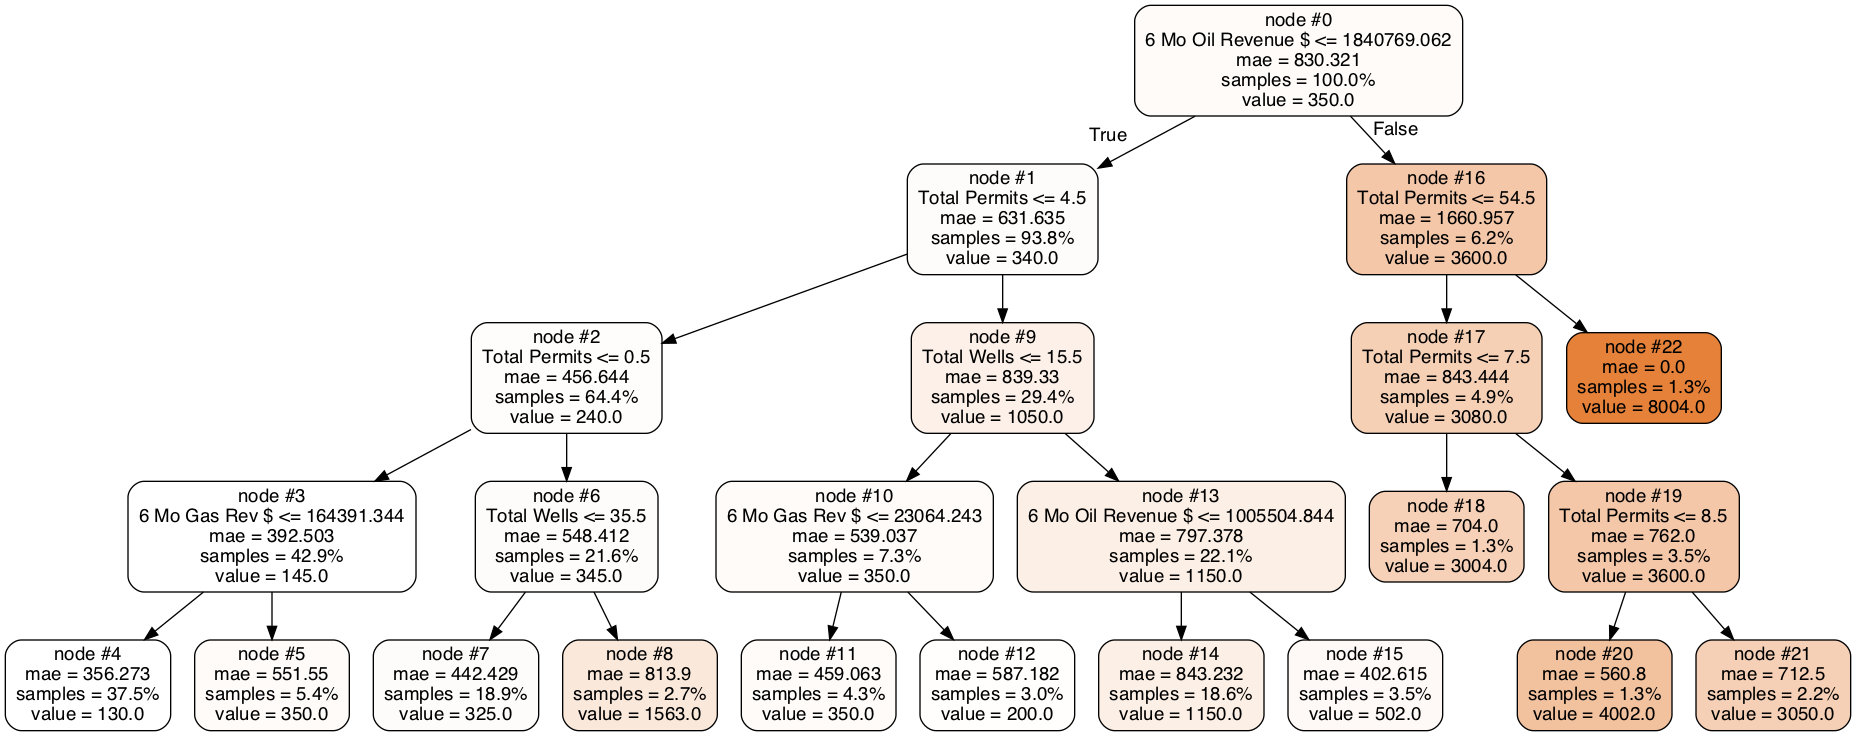

In [39]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(treeModel, out_file=dot_data, feature_names=inputs.columns,  
                filled=True, rounded=True,leaves_parallel = False, impurity = True,
                special_characters=False, node_ids = True, proportion = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [40]:
sampletreePredictions = treeModel.predict(scaler.inverse_transform(x_train))

In [41]:
metrics.mean_absolute_error(np.exp(y_train), sampletreePredictions)

509.1832884097035

### Iterating Tree Model with Different Parameters - Data is Scaled and Transformed (Inputs are standardized, Response is log transformed)

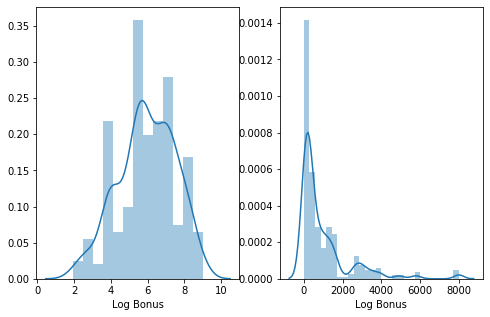

In [42]:
fig, ax = plt.subplots(1,2, figsize = (8,5))
sns.distplot(y_train, ax = ax[0])
sns.distplot(np.exp(y_train), ax = ax[1])

In [43]:
#creating empty arrays to store model data, error, information
error = []
varexp = []
treeModels = []
minSampleList = []
levels = []
minSamples = []

#looping through different sample minimums per leaf along with different levels
#running criterion on model as L1 loss function to reduce the sensitivity to outliars and large variance of response feature
for sample in range(2,16,2):
    for level in range(2,15):
        iterTreeMod = tree.DecisionTreeRegressor(criterion='mae', max_depth=level, min_samples_leaf=sample)
        iterTreeMod.fit(x_train, y_train)
        treeModels.append(iterTreeMod)
        minSamples.append(sample)
        levels.append(level)

for model in treeModels:
    error.append(metrics.mean_absolute_error(np.exp(y_train), np.exp(model.predict(x_train))))
    varexp.append(metrics.explained_variance_score(np.exp(y_train), np.exp(model.predict(x_train))))

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=13,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=14,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=13,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=14,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=13,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=14,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=13,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=14,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=8, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=13,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=14,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=13,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=14,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=12, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=2,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=3,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=6,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=7,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=8,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=9,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=11,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=12,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=13,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=14,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=14, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

<Figure size 864x504 with 0 Axes>

Text(0.5, 1.0, 'Absolute Mean Error vs Tree Branches - Colored by Min Sample Size in Each Leaf')

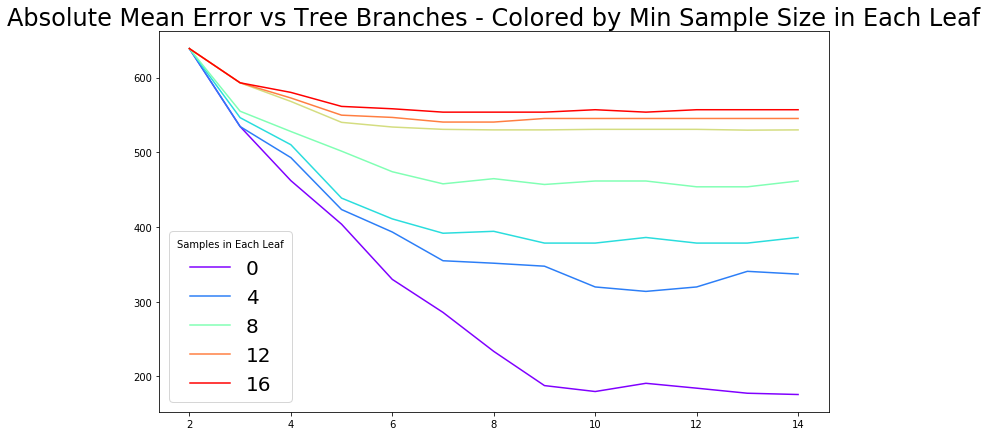

In [44]:
plt.figure(figsize=(12,7))
sns.lineplot(x=levels, y = error, hue = minSamples, palette="rainbow")
plt.title("Absolute Mean Error vs Tree Branches - Colored by Min Sample Size in Each Leaf", size = 24)
plt.legend(title = "Samples in Each Leaf", prop={'size': 20})

<Figure size 864x504 with 0 Axes>

Text(0.5, 1.0, 'Variance Explained vs Tree Branches - Colored by Min Sample Size in Each Leaf')

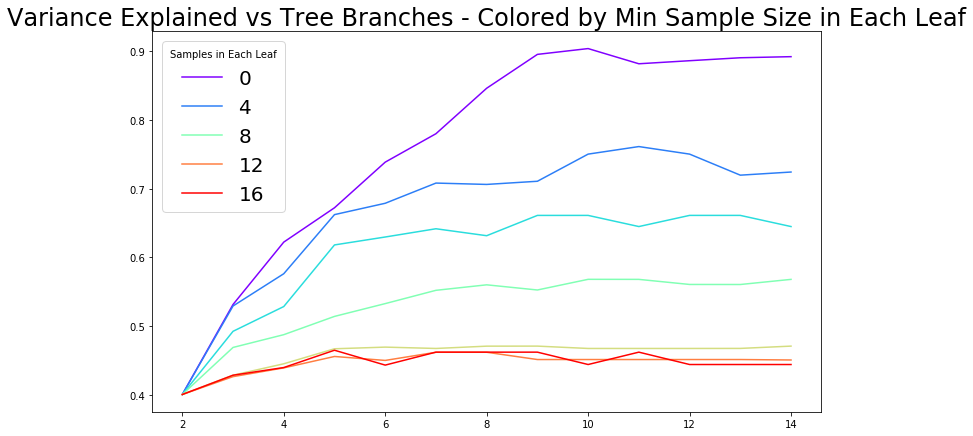

In [45]:
plt.figure(figsize=(12,7))
sns.lineplot(x=levels, y = varexp, hue = minSamples, palette="rainbow")
plt.title("Variance Explained vs Tree Branches - Colored by Min Sample Size in Each Leaf", size = 24)
plt.legend(title = "Samples in Each Leaf", prop={'size': 20})

* We see the most optimal model, one that does not overfit, while still producing an error under 400, appears to be model with 4 samples as minimum, and 6-8 levels

In [46]:
finalTreeModel = tree.DecisionTreeRegressor(criterion='mae', max_depth=8, min_samples_leaf=4)
finalTreeModel=finalTreeModel.fit(x_train,y_train)
treePredictions = np.exp(finalTreeModel.predict(x_train))


In [47]:
modelPerformance(np.exp(y_train), treePredictions)

Mean Absolute Error: 344.3908355795148 
Variance Explained: 0.7178753479180664 
R2 Score: 0.7066556185626212


In [48]:
treeResults = pd.DataFrame()
treeResults["Actual Bonus"] = np.exp(y_train)
treeResults["Tree Predicted Bonus"] = treePredictions
treeResults

,Actual Bonus,Tree Predicted Bonus
LeaseIndex,,
2505,55.0,350.000000
2502,2750.0,570.000000
2704,350.0,350.000000
3072,50.0,52.000000
2356,1500.0,2085.665361
2507,2800.0,350.000000
1858,451.0,1220.698161
3079,300.0,570.000000
3255,13.0,45.000000


In [49]:
resultsConcat = pd.concat([resultsConcat, treeResults["Tree Predicted Bonus"]], axis=1, join="inner")

In [50]:
resultsConcat["Diff Linear vs Tree"] = resultsConcat["Predicted"] - resultsConcat["Tree Predicted Bonus"]

In [51]:

resultsConcat.describe().T

,count,mean,std,min,25%,50%,75%,max
Bonus,371.0,990.654987,1417.418897,7.000000,147.500000,350.0,1201.0,8004.0
Section,371.0,18.760108,10.633660,1.000000,9.000000,19.0,28.0,36.0
Township,371.0,38.226415,1.071726,37.000000,37.000000,38.0,39.0,40.0
Range,371.0,72.110512,1.008704,70.000000,71.500000,72.0,73.0,74.0
Total Permits,371.0,6.150943,13.323780,0.000000,0.000000,1.0,7.0,124.0
Total Wells,371.0,17.773585,15.641506,1.000000,3.000000,13.0,29.0,55.0
Avg First 6 Mo Oil,371.0,10011.646900,11160.853019,0.000000,3090.000000,7282.0,12277.0,82446.0
Avg First 6 Mo Gas,371.0,15269.902965,25446.200952,0.000000,1754.000000,3628.0,20281.0,197850.0
Qi Oil,371.0,2619.509434,3084.854426,0.000000,795.000000,1790.0,3104.0,26010.0
Qi Gas,371.0,4281.234501,7689.151727,0.000000,314.000000,816.0,4620.0,40644.0


## Testing Tree and Linear Model on Y Test

In [52]:
linearTest = np.exp(reg.predict(x_test))
print("Linear Model")
modelPerformance(np.exp(y_test), linearTest)


treeTest = np.exp(finalTreeModel.predict(x_test))
print("\nDecision Tree")
modelPerformance(np.exp(y_test), treeTest)

Linear Model
Mean Absolute Error: 880.9124659663399 
Variance Explained: -1.9842780934169775 
R2 Score: -2.00268352390639

Decision Tree
Mean Absolute Error: 544.7071217040096 
Variance Explained: 0.6369715383071626 
R2 Score: 0.6322131758093601



## Applying Model to Sales Tracts

### Data Preparation

In [53]:
%store -r saleDate
%store -r tractshp
%store -r AOI

In [54]:
#adding record date to tractshp in order for it to work with getTrainingMeasures functions
tractshp["Record Date"] = saleDate

#filtering leaes within AOI where model data was built on
leasesInAOI = tractshp.loc[tractshp["geometry"].within(AOI["geometry"].iloc[0])]

### Looping through all tracts within selected AOI to gather permit and production data

In [55]:
%store

Stored variables and their in-db values:
AOI                               ->    FID                                           g
MLPredandResponseCols             -> ['Bonus', 'Total Permits', 'Total Wells', 'Avg Fir
gasPrices                         ->             Gas Price
Date                 
2000-0
milesbuffer                       -> 4828.0199999999995
oilPrices                         ->             WTI Price
Date                 
2000-0
permitshp                         ->          API10UWI District  FiledDate  AprvdDate  
prodshp                           ->                APIUWI                             
saleDate                          -> Timestamp('2020-03-23 00:00:00')
tractshp                          ->       SaleParcel  lot_no  tract_id       short_cod


In [56]:
%store -r prodshp
%store -r permitshp

In [57]:
for i in leasesInAOI.index:
    getTrainingMeasures(leasesInAOI, i, prodshp, permitshp)

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 16789  4900948392     None       NaT 2020-01-28 2022-01-27    WY   
 19790  4900948280     None       NaT 2020-01-28 2022-01-27    WY   
 21385  4900943869     None       NaT 2019-01-17 2021-01-16    WY   
 22427  4900942810     None       NaT 2018-12-27 2020-12-26    WY   
 22435  4900941533     None       NaT 2018-12-27 2020-12-26    WY   
 22524  4900943868     None       NaT 2019-01-17 2021-01-16    WY   
 22959  4900948278     None       NaT 2020-01-28 2022-01-27    WY   
 25458  4900942825     None       NaT 2018-12-27 2020-12-26    WY   
 27787  4900948279     None       NaT 2020-01-28 2022-01-27    WY   
 40327  4900941632     None       NaT 2018-12-27 2020-12-26    WY   
 40330  4900942079     None       NaT 2018-12-27 2020-12-26    WY   
 46037  4900942077     None       NaT 2018-12-27 2020-12-26    WY   
 
               County OpAlias        LeaseName          WellNo  ... Field  \
 16789  CONVERSE (WY)   

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 16789  4900948392     None       NaT 2020-01-28 2022-01-27    WY   
 19790  4900948280     None       NaT 2020-01-28 2022-01-27    WY   
 21385  4900943869     None       NaT 2019-01-17 2021-01-16    WY   
 22435  4900941533     None       NaT 2018-12-27 2020-12-26    WY   
 22524  4900943868     None       NaT 2019-01-17 2021-01-16    WY   
 22959  4900948278     None       NaT 2020-01-28 2022-01-27    WY   
 27787  4900948279     None       NaT 2020-01-28 2022-01-27    WY   
 40327  4900941632     None       NaT 2018-12-27 2020-12-26    WY   
 40330  4900942079     None       NaT 2018-12-27 2020-12-26    WY   
 46037  4900942077     None       NaT 2018-12-27 2020-12-26    WY   
 
               County OpAlias        LeaseName          WellNo  ... Field  \
 16789  CONVERSE (WY)   DEVON  SDU TILLARD FED  02-113771-7XNH  ...    WC   
 19790  CONVERSE (WY)   DEVON  SDU TILLARD FED  12-013771-5XNH  ...    WC   
 21385  

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 9059   4900940541     None       NaT 2018-06-15 2020-06-14    WY   
 21385  4900943869     None       NaT 2019-01-17 2021-01-16    WY   
 22427  4900942810     None       NaT 2018-12-27 2020-12-26    WY   
 22431  4900942811     None       NaT 2018-12-27 2020-12-26    WY   
 22435  4900941533     None       NaT 2018-12-27 2020-12-26    WY   
 22524  4900943868     None       NaT 2019-01-17 2021-01-16    WY   
 25458  4900942825     None       NaT 2018-12-27 2020-12-26    WY   
 29920  4900942809     None       NaT 2018-12-27 2020-12-26    WY   
 40325  4900942812     None       NaT 2018-12-27 2020-12-26    WY   
 40327  4900941632     None       NaT 2018-12-27 2020-12-26    WY   
 40330  4900942079     None       NaT 2018-12-27 2020-12-26    WY   
 45097  4900946701     None       NaT 2019-06-06 2021-06-05    WY   
 46037  4900942077     None       NaT 2018-12-27 2020-12-26    WY   
 
               County OpAlias   

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 3585   4900937066     None       NaT 2019-09-18 2021-09-17    WY   
 8838   4900946613     None       NaT 2019-09-18 2021-09-17    WY   
 8839   4900946614     None       NaT 2019-09-18 2021-09-17    WY   
 15615  4900937057     None       NaT 2019-09-18 2021-09-17    WY   
 16450  4900937053     None       NaT 2019-09-18 2021-09-17    WY   
 16452  4900946611     None       NaT 2019-09-18 2021-09-17    WY   
 19217  4900938466     None       NaT 2019-02-07 2021-02-06    WY   
 25694  4900938469     None       NaT 2019-02-07 2021-02-06    WY   
 36837  4900938468     None       NaT 2019-02-07 2021-02-06    WY   
 36842  4900938467     None       NaT 2019-02-07 2021-02-06    WY   
 41511  4900938408     None       NaT 2018-12-26 2020-12-25    WY   
 
               County OpAlias   LeaseName           WellNo  ... Field  \
 3585   CONVERSE (WY)   DEVON         WYO      163971-4TUH  ...    WC   
 8838   CONVERSE (WY)   

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 3585   4900937066     None       NaT 2019-09-18 2021-09-17    WY   
 8838   4900946613     None       NaT 2019-09-18 2021-09-17    WY   
 8839   4900946614     None       NaT 2019-09-18 2021-09-17    WY   
 15615  4900937057     None       NaT 2019-09-18 2021-09-17    WY   
 16450  4900937053     None       NaT 2019-09-18 2021-09-17    WY   
 16452  4900946611     None       NaT 2019-09-18 2021-09-17    WY   
 19217  4900938466     None       NaT 2019-02-07 2021-02-06    WY   
 19662  4900938452     None       NaT 2020-01-09 2022-01-08    WY   
 21261  4900941634     None       NaT 2018-12-21 2020-12-20    WY   
 22752  4900938451     None       NaT 2019-05-29 2021-05-28    WY   
 25694  4900938469     None       NaT 2019-02-07 2021-02-06    WY   
 26175  4900941635     None       NaT 2018-12-21 2020-12-20    WY   
 26238  4900938423     None       NaT 2019-02-19 2021-02-18    WY   
 26239  4900938424     None       

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 3585   4900937066     None       NaT 2019-09-18 2021-09-17    WY   
 8838   4900946613     None       NaT 2019-09-18 2021-09-17    WY   
 8839   4900946614     None       NaT 2019-09-18 2021-09-17    WY   
 15615  4900937057     None       NaT 2019-09-18 2021-09-17    WY   
 16450  4900937053     None       NaT 2019-09-18 2021-09-17    WY   
 16452  4900946611     None       NaT 2019-09-18 2021-09-17    WY   
 19217  4900938466     None       NaT 2019-02-07 2021-02-06    WY   
 25694  4900938469     None       NaT 2019-02-07 2021-02-06    WY   
 36837  4900938468     None       NaT 2019-02-07 2021-02-06    WY   
 36842  4900938467     None       NaT 2019-02-07 2021-02-06    WY   
 41511  4900938408     None       NaT 2018-12-26 2020-12-25    WY   
 
               County OpAlias   LeaseName           WellNo  ... Field  \
 3585   CONVERSE (WY)   DEVON         WYO      163971-4TUH  ...    WC   
 8838   CONVERSE (WY)   

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 2849   4900937397     None       NaT 2019-09-16 2021-09-15    WY   
 3426   4900937409     None       NaT 2019-08-21 2021-08-20    WY   
 3585   4900937066     None       NaT 2019-09-18 2021-09-17    WY   
 5995   4900937408     None       NaT 2019-08-21 2021-08-20    WY   
 8833   4900937396     None       NaT 2019-09-16 2021-09-15    WY   
 8838   4900946613     None       NaT 2019-09-18 2021-09-17    WY   
 8839   4900946614     None       NaT 2019-09-18 2021-09-17    WY   
 9498   4900937834     None       NaT 2019-08-23 2021-08-22    WY   
 9499   4900937838     None       NaT 2019-08-23 2021-08-22    WY   
 9501   4900937835     None       NaT 2019-08-23 2021-08-22    WY   
 9502   4900937837     None       NaT 2019-08-23 2021-08-22    WY   
 13472  4900937399     None       NaT 2019-09-16 2021-09-15    WY   
 14450  4900937405     None       NaT 2019-08-21 2021-08-20    WY   
 15461  4900937836     None       

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 2849   4900937397     None       NaT 2019-09-16 2021-09-15    WY   
 3585   4900937066     None       NaT 2019-09-18 2021-09-17    WY   
 5995   4900937408     None       NaT 2019-08-21 2021-08-20    WY   
 8833   4900937396     None       NaT 2019-09-16 2021-09-15    WY   
 8838   4900946613     None       NaT 2019-09-18 2021-09-17    WY   
 8839   4900946614     None       NaT 2019-09-18 2021-09-17    WY   
 9498   4900937834     None       NaT 2019-08-23 2021-08-22    WY   
 9499   4900937838     None       NaT 2019-08-23 2021-08-22    WY   
 9501   4900937835     None       NaT 2019-08-23 2021-08-22    WY   
 15462  4900937840     None       NaT 2019-08-23 2021-08-22    WY   
 15615  4900937057     None       NaT 2019-09-18 2021-09-17    WY   
 16450  4900937053     None       NaT 2019-09-18 2021-09-17    WY   
 16452  4900946611     None       NaT 2019-09-18 2021-09-17    WY   
 
               County OpAlias Le

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 3585   4900937066     None       NaT 2019-09-18 2021-09-17    WY   
 8569   4900945450     None       NaT 2019-04-29 2021-04-28    WY   
 8838   4900946613     None       NaT 2019-09-18 2021-09-17    WY   
 8839   4900946614     None       NaT 2019-09-18 2021-09-17    WY   
 10648  4900941626     None       NaT 2019-04-29 2021-04-28    WY   
 15615  4900937057     None       NaT 2019-09-18 2021-09-17    WY   
 16450  4900937053     None       NaT 2019-09-18 2021-09-17    WY   
 16452  4900946611     None       NaT 2019-09-18 2021-09-17    WY   
 19217  4900938466     None       NaT 2019-02-07 2021-02-06    WY   
 19662  4900938452     None       NaT 2020-01-09 2022-01-08    WY   
 20622  4900945449     None       NaT 2019-04-29 2021-04-28    WY   
 22752  4900938451     None       NaT 2019-05-29 2021-05-28    WY   
 25694  4900938469     None       NaT 2019-02-07 2021-02-06    WY   
 26238  4900938423     None       

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 3585   4900937066     None       NaT 2019-09-18 2021-09-17    WY   
 4386   4900938414     None       NaT 2018-05-17 2020-05-16    WY   
 8569   4900945450     None       NaT 2019-04-29 2021-04-28    WY   
 8838   4900946613     None       NaT 2019-09-18 2021-09-17    WY   
 8839   4900946614     None       NaT 2019-09-18 2021-09-17    WY   
 10648  4900941626     None       NaT 2019-04-29 2021-04-28    WY   
 11071  4900940385     None       NaT 2018-05-18 2020-05-17    WY   
 15615  4900937057     None       NaT 2019-09-18 2021-09-17    WY   
 16450  4900937053     None       NaT 2019-09-18 2021-09-17    WY   
 16452  4900946611     None       NaT 2019-09-18 2021-09-17    WY   
 19035  4900940342     None       NaT 2018-05-18 2020-05-17    WY   
 19217  4900938466     None       NaT 2019-02-07 2021-02-06    WY   
 19662  4900938452     None       NaT 2020-01-09 2022-01-08    WY   
 20622  4900945449     None       

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 3585   4900937066     None       NaT 2019-09-18 2021-09-17    WY   
 8569   4900945450     None       NaT 2019-04-29 2021-04-28    WY   
 8838   4900946613     None       NaT 2019-09-18 2021-09-17    WY   
 8839   4900946614     None       NaT 2019-09-18 2021-09-17    WY   
 10648  4900941626     None       NaT 2019-04-29 2021-04-28    WY   
 15615  4900937057     None       NaT 2019-09-18 2021-09-17    WY   
 16450  4900937053     None       NaT 2019-09-18 2021-09-17    WY   
 16452  4900946611     None       NaT 2019-09-18 2021-09-17    WY   
 19217  4900938466     None       NaT 2019-02-07 2021-02-06    WY   
 19662  4900938452     None       NaT 2020-01-09 2022-01-08    WY   
 20622  4900945449     None       NaT 2019-04-29 2021-04-28    WY   
 22752  4900938451     None       NaT 2019-05-29 2021-05-28    WY   
 25694  4900938469     None       NaT 2019-02-07 2021-02-06    WY   
 26238  4900938423     None       

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 3585   4900937066     None       NaT 2019-09-18 2021-09-17    WY   
 8569   4900945450     None       NaT 2019-04-29 2021-04-28    WY   
 8838   4900946613     None       NaT 2019-09-18 2021-09-17    WY   
 8839   4900946614     None       NaT 2019-09-18 2021-09-17    WY   
 10648  4900941626     None       NaT 2019-04-29 2021-04-28    WY   
 15615  4900937057     None       NaT 2019-09-18 2021-09-17    WY   
 16450  4900937053     None       NaT 2019-09-18 2021-09-17    WY   
 16452  4900946611     None       NaT 2019-09-18 2021-09-17    WY   
 19217  4900938466     None       NaT 2019-02-07 2021-02-06    WY   
 20622  4900945449     None       NaT 2019-04-29 2021-04-28    WY   
 25694  4900938469     None       NaT 2019-02-07 2021-02-06    WY   
 36837  4900938468     None       NaT 2019-02-07 2021-02-06    WY   
 36842  4900938467     None       NaT 2019-02-07 2021-02-06    WY   
 41511  4900938408     None       

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 3585   4900937066     None       NaT 2019-09-18 2021-09-17    WY   
 8838   4900946613     None       NaT 2019-09-18 2021-09-17    WY   
 8839   4900946614     None       NaT 2019-09-18 2021-09-17    WY   
 15615  4900937057     None       NaT 2019-09-18 2021-09-17    WY   
 16450  4900937053     None       NaT 2019-09-18 2021-09-17    WY   
 16452  4900946611     None       NaT 2019-09-18 2021-09-17    WY   
 19217  4900938466     None       NaT 2019-02-07 2021-02-06    WY   
 25694  4900938469     None       NaT 2019-02-07 2021-02-06    WY   
 36837  4900938468     None       NaT 2019-02-07 2021-02-06    WY   
 36842  4900938467     None       NaT 2019-02-07 2021-02-06    WY   
 
               County OpAlias   LeaseName           WellNo  ... Field  \
 3585   CONVERSE (WY)   DEVON         WYO      163971-4TUH  ...    WC   
 8838   CONVERSE (WY)   DEVON     JRJ FED      153971-4TLH  ...    WC   
 8839   CONVERSE (WY

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 4960   4900940043     None       NaT 2020-02-26 2022-02-25    WY   
 9945   4900940042     None       NaT 2020-02-26 2022-02-25    WY   
 14867  4900941928     None       NaT 2020-02-19 2022-02-18    WY   
 15830  4900941395     None       NaT 2020-02-18 2022-02-17    WY   
 15908  4900941359     None       NaT 2020-02-27 2022-02-26    WY   
 15909  4900941358     None       NaT 2020-02-27 2022-02-26    WY   
 15914  4900941702     None       NaT 2020-02-27 2022-02-26    WY   
 15915  4900941700     None       NaT 2020-02-27 2022-02-26    WY   
 16673  4900941387     None       NaT 2020-01-07 2022-01-06    WY   
 16675  4900941379     None       NaT 2020-01-07 2022-01-06    WY   
 16927  4900941906     None       NaT 2020-02-19 2022-02-18    WY   
 16928  4900941910     None       NaT 2020-02-19 2022-02-18    WY   
 18619  4900941388     None       NaT 2020-01-07 2022-01-06    WY   
 18621  4900941380     None       

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 4960   4900940043     None       NaT 2020-02-26 2022-02-25    WY   
 9945   4900940042     None       NaT 2020-02-26 2022-02-25    WY   
 14867  4900941928     None       NaT 2020-02-19 2022-02-18    WY   
 15914  4900941702     None       NaT 2020-02-27 2022-02-26    WY   
 15915  4900941700     None       NaT 2020-02-27 2022-02-26    WY   
 16673  4900941387     None       NaT 2020-01-07 2022-01-06    WY   
 16675  4900941379     None       NaT 2020-01-07 2022-01-06    WY   
 18619  4900941388     None       NaT 2020-01-07 2022-01-06    WY   
 18621  4900941380     None       NaT 2020-01-07 2022-01-06    WY   
 18998  4900941386     None       NaT 2020-03-17 2022-03-17    WY   
 27909  4900941701     None       NaT 2020-02-18 2022-02-17    WY   
 27928  4900941927     None       NaT 2020-02-19 2022-02-18    WY   
 27959  4900943141     None       NaT 2020-02-27 2022-02-26    WY   
 30998  4900941384     None       

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 4960   4900940043     None       NaT 2020-02-26 2022-02-25    WY   
 9945   4900940042     None       NaT 2020-02-26 2022-02-25    WY   
 14867  4900941928     None       NaT 2020-02-19 2022-02-18    WY   
 15914  4900941702     None       NaT 2020-02-27 2022-02-26    WY   
 15915  4900941700     None       NaT 2020-02-27 2022-02-26    WY   
 16673  4900941387     None       NaT 2020-01-07 2022-01-06    WY   
 16675  4900941379     None       NaT 2020-01-07 2022-01-06    WY   
 18619  4900941388     None       NaT 2020-01-07 2022-01-06    WY   
 18621  4900941380     None       NaT 2020-01-07 2022-01-06    WY   
 18998  4900941386     None       NaT 2020-03-17 2022-03-17    WY   
 27909  4900941701     None       NaT 2020-02-18 2022-02-17    WY   
 27928  4900941927     None       NaT 2020-02-19 2022-02-18    WY   
 27959  4900943141     None       NaT 2020-02-27 2022-02-26    WY   
 30998  4900941384     None       

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 4960   4900940043     None       NaT 2020-02-26 2022-02-25    WY   
 9945   4900940042     None       NaT 2020-02-26 2022-02-25    WY   
 15914  4900941702     None       NaT 2020-02-27 2022-02-26    WY   
 15915  4900941700     None       NaT 2020-02-27 2022-02-26    WY   
 27909  4900941701     None       NaT 2020-02-18 2022-02-17    WY   
 27959  4900943141     None       NaT 2020-02-27 2022-02-26    WY   
 43631  4900936266     None       NaT 2019-06-18 2021-06-17    WY   
 43638  4900936264     None       NaT 2019-06-18 2021-06-17    WY   
 43654  4900936265     None       NaT 2019-06-18 2021-06-17    WY   
 
               County                   OpAlias         LeaseName  \
 4960   CONVERSE (WY)         EOG RESOURCES INC         AMBERJACK   
 9945   CONVERSE (WY)         EOG RESOURCES INC         AMBERJACK   
 15914  CONVERSE (WY)    ELEPHANT OPERATING LLC            NIMITZ   
 15915  CONVERSE (WY)    ELEPHAN

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 7855   4900941111     None       NaT 2019-07-31 2021-07-30    WY   
 43631  4900936266     None       NaT 2019-06-18 2021-06-17    WY   
 43638  4900936264     None       NaT 2019-06-18 2021-06-17    WY   
 43654  4900936265     None       NaT 2019-06-18 2021-06-17    WY   
 
               County                   OpAlias   LeaseName           WellNo  \
 7855   CONVERSE (WY)      WOLD ENERGY PARTNERS   PATTERSON  3874-22-15-3BFH   
 43631  CONVERSE (WY)  WOLD ENERGY PARTNERS LLC  HORNBUCKLE  3873-20-17-2F3H   
 43638  CONVERSE (WY)  WOLD ENERGY PARTNERS LLC  HORNBUCKLE   3873-20-17-2FH   
 43654  CONVERSE (WY)      WOLD ENERGY PARTNERS  HORNBUCKLE  3873-20-17-2F2H   
 
        ...       Field   Latitude   Longitude    Btm_Lat     Btm_Lon  \
 7855   ...          WC  43.244405 -105.727230  43.271349 -105.727695   
 43631  ...  HORNBUCKLE  43.245676 -105.649682  43.271898 -105.643998   
 43638  ...  HORNBUCKLE  43.2452

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

(         API10UWI District FiledDate  AprvdDate    ExpDate State  \
 9945   4900940042     None       NaT 2020-02-26 2022-02-25    WY   
 15914  4900941702     None       NaT 2020-02-27 2022-02-26    WY   
 27909  4900941701     None       NaT 2020-02-18 2022-02-17    WY   
 27959  4900943141     None       NaT 2020-02-27 2022-02-26    WY   
 43631  4900936266     None       NaT 2019-06-18 2021-06-17    WY   
 43638  4900936264     None       NaT 2019-06-18 2021-06-17    WY   
 43654  4900936265     None       NaT 2019-06-18 2021-06-17    WY   
 
               County                   OpAlias         LeaseName  \
 9945   CONVERSE (WY)         EOG RESOURCES INC         AMBERJACK   
 15914  CONVERSE (WY)    ELEPHANT OPERATING LLC            NIMITZ   
 27909  CONVERSE (WY)    ELEPHANT OPERATING LLC            NIMITZ   
 27959  CONVERSE (WY)    ELEPHANT OPERATING LLC  NIMITZ 3873-1522   
 43631  CONVERSE (WY)  WOLD ENERGY PARTNERS LLC        HORNBUCKLE   
 43638  CONVERSE (WY)  WOLD ENER

In [58]:
#detecting null columns that may have occured when getting training measures that did not have wells to generate revenue, Qi oil, etc
nullCols = leasesInAOI.columns[leasesInAOI.isnull().any()]

In [59]:
#filling null values with a loop, as df.fillna does not work on a geo dataframe - therefore have to iterate through columns
nullCols
for col in nullCols:
    leasesInAOI[col].fillna(0,inplace=True)

Index(['Avg First 6 Mo Oil', 'Avg First 6 Mo Gas', 'Qi Oil', 'Qi Gas',
       '6 Mo Oil Revenue $', '6 Mo Gas Rev $'],
      dtype='object')

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [60]:
#exporting training measures on sale tracts to file
leasesInAOI.to_excel("Output Data/Sale Tracts Learning Measures.xlsx")

### Read In Prepared Data
### Preparing model by gathering inputs, scaling, and predicting based on training model

In [61]:
#reading in leasesinAOI from file for model
leasesInAOI = pd.read_excel("Output Data/Sale Tracts Learning Measures.xlsx", index_col = 0)
leasesInAOI.head()

,SaleParcel,lot_no,tract_id,short_code,label,geometry,centroids,Acres,buffers,Permit Summary,...,Total Permits,Total Wells,Avg First 6 Mo Oil,Avg First 6 Mo Gas,Qi Oil,Qi Gas,6 Mo Oil Revenue $,6 Mo Gas Rev $,Oil Price,Gas Price
16,WY-201Q-014,64921,40,BLMWY-2020-Q1-3,WY-2020-03-6317,"POLYGON ((470775.3766748243 4783849.638091538,...",POINT (469958.273277905 4783844.910772996),325,"POLYGON ((474786.293277905 4783844.910772996, ...",In a 3 mile radius there are 12 active permits...,...,12,6,107657.200000,85665.000000,26755.000000,20090.000000,2.691430e+06,153340.350000,25,1.79
17,WY-201Q-100,65007,41,BLMWY-2020-Q1-3,WY-2020-03-6318,"POLYGON ((470776.0512321209 4785061.1477955, 4...",POINT (469953.1518195324 4784853.058404164),166,"POLYGON ((474781.1718195324 4784853.058404164,...",In a 3 mile radius there are 10 active permits...,...,10,5,107657.200000,85665.000000,27732.000000,18996.000000,2.691430e+06,153340.350000,25,1.79
18,WY-201Q-101,65008,42,BLMWY-2020-Q1-3,WY-2020-03-6319,MULTIPOLYGON (((467495.5528191004 4784235.8869...,POINT (467757.130082407 4784036.616042774),494,"POLYGON ((472585.150082407 4784036.616042774, ...",In a 3 mile radius there are 13 active permits...,...,13,10,122775.000000,85716.833333,27903.000000,18525.000000,3.069375e+06,153433.131667,25,1.79
19,WY-201Q-015,64922,45,BLMWY-2020-Q1-3,WY-2020-03-6324,MULTIPOLYGON (((466663.7560363491 4802008.3005...,POINT (468832.8359083962 4802293.450434712),1539,"POLYGON ((473660.8559083962 4802293.450434712,...",In a 3 mile radius there are 11 active permits...,...,11,15,84078.600000,136917.200000,19838.000000,32556.000000,2.101965e+06,245081.788000,25,1.79
20,WY-201Q-102,65009,44,BLMWY-2020-Q1-3,WY-2020-03-6322,"POLYGON ((467881.7929990217 4802005.905810955,...",POINT (467608.471182364 4801534.516088142),243,"POLYGON ((472436.491182364 4801534.516088142, ...",In a 3 mile radius there are 20 active permits...,...,20,22,103078.416667,211061.500000,23465.454545,38686.363636,2.576960e+06,377800.085000,25,1.79


### Scaling Inputs and Predicting Bonuses Based on Models

In [62]:
#getting inputs based on the model defined before
inputsTractProjection = leasesInAOI[inputs.columns]

#scaling independent variables and tranforming
scaler.fit(inputsTractProjection)
inputsTractProjection = scaler.transform(inputsTractProjection)

#predicting bonuses
projBonus = reg.predict(inputsTractProjection)

#creating column for projected Bonuses
leasesInAOI["Projected Bonus"] = np.exp(projBonus)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [63]:
leasesInAOI["Tree Predicted Bonus"] = np.exp(finalTreeModel.predict(inputsTractProjection))

In [64]:
#rounding numeric values for cleaner presentation
leasesInAOI = leasesInAOI.round()

In [65]:
#Since we had model error - we will use it to get an estimated range  - since this model tended to underestimate - we will use the projected value x only 75% to get low end and 200% to get highend

In [66]:
def getBidIntervals(lowEndRate, highEndRate, BaseBonus):
    
    '''
    This function will create an interval based on adjustments to the projected BaseBonus prices
    BaseBonus price will be a pandas series
    lowEndRate and highEndRate will be user defined based on the error of the model
    Basebonus will be a pandas series and the function should be called on the dataframe apply method
    '''
    
    lowProjection = BaseBonus * lowEndRate
    highProjection = BaseBonus * highEndRate
    average = (lowProjection + highProjection) /2
    
    return [lowProjection, highProjection]
    

In [67]:
leasesInAOI["Expected Bonus Range"] = leasesInAOI["Projected Bonus"].apply(lambda x: getBidIntervals(.75, 2, x))

In [68]:
leasesInAOI

,SaleParcel,lot_no,tract_id,short_code,label,geometry,centroids,Acres,buffers,Permit Summary,...,Avg First 6 Mo Gas,Qi Oil,Qi Gas,6 Mo Oil Revenue $,6 Mo Gas Rev $,Oil Price,Gas Price,Projected Bonus,Tree Predicted Bonus,Expected Bonus Range
16,WY-201Q-014,64921,40,BLMWY-2020-Q1-3,WY-2020-03-6317,"POLYGON ((470775.3766748243 4783849.638091538,...",POINT (469958.273277905 4783844.910772996),325,"POLYGON ((474786.293277905 4783844.910772996, ...",In a 3 mile radius there are 12 active permits...,...,85665.0,26755.0,20090.0,2691430.0,153340.0,25,2.0,347.0,250.0,"[260.25, 694.0]"
17,WY-201Q-100,65007,41,BLMWY-2020-Q1-3,WY-2020-03-6318,"POLYGON ((470776.0512321209 4785061.1477955, 4...",POINT (469953.1518195324 4784853.058404164),166,"POLYGON ((474781.1718195324 4784853.058404164,...",In a 3 mile radius there are 10 active permits...,...,85665.0,27732.0,18996.0,2691430.0,153340.0,25,2.0,287.0,250.0,"[215.25, 574.0]"
18,WY-201Q-101,65008,42,BLMWY-2020-Q1-3,WY-2020-03-6319,MULTIPOLYGON (((467495.5528191004 4784235.8869...,POINT (467757.130082407 4784036.616042774),494,"POLYGON ((472585.150082407 4784036.616042774, ...",In a 3 mile radius there are 13 active permits...,...,85717.0,27903.0,18525.0,3069375.0,153433.0,25,2.0,532.0,620.0,"[399.0, 1064.0]"
19,WY-201Q-015,64922,45,BLMWY-2020-Q1-3,WY-2020-03-6324,MULTIPOLYGON (((466663.7560363491 4802008.3005...,POINT (468832.8359083962 4802293.450434712),1539,"POLYGON ((473660.8559083962 4802293.450434712,...",In a 3 mile radius there are 11 active permits...,...,136917.0,19838.0,32556.0,2101965.0,245082.0,25,2.0,427.0,100.0,"[320.25, 854.0]"
20,WY-201Q-102,65009,44,BLMWY-2020-Q1-3,WY-2020-03-6322,"POLYGON ((467881.7929990217 4802005.905810955,...",POINT (467608.471182364 4801534.516088142),243,"POLYGON ((472436.491182364 4801534.516088142, ...",In a 3 mile radius there are 20 active permits...,...,211062.0,23465.0,38686.0,2576960.0,377800.0,25,2.0,1222.0,1700.0,"[916.5, 2444.0]"
21,WY-201Q-016,64923,49,BLMWY-2020-Q1-3,WY-2020-03-6340,"POLYGON ((468685.6574361854 4801198.093584971,...",POINT (468890.6774940442 4801400.067115995),40,"POLYGON ((473718.6974940442 4801400.067115995,...",In a 3 mile radius there are 11 active permits...,...,117010.0,17924.0,28632.0,1859872.0,209447.0,25,2.0,360.0,100.0,"[270.0, 720.0]"
22,WY-201Q-017,64924,46,BLMWY-2020-Q1-3,WY-2020-03-6331,"POLYGON ((472330.6638150535 4800025.069974388,...",POINT (471858.2048892394 4800294.277369834),243,"POLYGON ((476686.2248892394 4800294.277369834,...",In a 3 mile radius there are 22 active permits...,...,190096.0,22800.0,45960.0,2316950.0,340272.0,25,2.0,396.0,1221.0,"[297.0, 792.0]"
23,WY-201Q-103,65010,60,BLMWY-2020-Q1-3,WY-2020-03-6401,"POLYGON ((471122.0037354486 4801241.216803673,...",POINT (471114.8075752032 4800429.924610612),325,"POLYGON ((475942.8275752033 4800429.924610612,...",In a 3 mile radius there are 13 active permits...,...,190096.0,22800.0,45960.0,2316950.0,340272.0,25,2.0,221.0,450.0,"[165.75, 442.0]"
24,WY-201Q-018,64925,47,BLMWY-2020-Q1-3,WY-2020-03-6333,MULTIPOLYGON (((467066.8207937301 4801197.1337...,POINT (467602.4846453754 4799779.674300328),243,"POLYGON ((472430.5046453754 4799779.674300328,...",In a 3 mile radius there are 21 active permits...,...,155514.0,23270.0,28696.0,2668385.0,278371.0,25,2.0,958.0,1700.0,"[718.5, 1916.0]"
25,WY-201Q-019,64926,51,BLMWY-2020-Q1-3,WY-2020-03-6345,"POLYGON ((465830.3683772773 4798767.101425705,...",POINT (465426.4270627511 4798968.314839863),243,"POLYGON ((470254.4470627511 4798968.314839863,...",In a 3 mile radius there are 25 active permits...,...,147115.0,25604.0,30786.0,2790265.0,263336.0,25,2.0,1768.0,302.0,"[1326.0, 3536.0]"


## Sales Results - Compare Projected Prices vs What was Sold

### Reading sales results excel file

In [69]:
salesResults = pd.read_excel('Data/Sales_Results.xlsx', header = 4)
#removing unamed null columns
salesResults = salesResults.drop(columns = salesResults.columns[[1,-1]])
#renaming column for merging
salesResults.rename(columns = {'PAR': 'Label Code'}, inplace = True)

In [70]:
#generating label code from sales results to make a primary key to join published sale results with presale codes
leasesInAOI["Label Code"] = leasesInAOI["label"].apply(lambda x: int(x.split('-')[3]))

In [71]:
#checking datatypes to ensure matching column for joining contain same datatype
salesResults.dtypes
leasesInAOI.dtypes

SERIAL         object
Label Code     object
NAME           object
ADDRESS        object
CITY           object
ST             object
ZIP            object
Bid/Acre       object
ACRES          object
Total Bonus    object
dtype: object

SaleParcel                        object
lot_no                             int64
tract_id                           int64
short_code                        object
label                             object
geometry                          object
centroids                         object
Acres                              int64
buffers                           object
Permit Summary                    object
Leases Summary                    object
Old Production Summary            object
Recent Prod Summary               object
Record Date               datetime64[ns]
Total Permits                      int64
Total Wells                        int64
Avg First 6 Mo Oil               float64
Avg First 6 Mo Gas               float64
Qi Oil                           float64
Qi Gas                           float64
6 Mo Oil Revenue $               float64
6 Mo Gas Rev $                   float64
Oil Price                          int64
Gas Price                        float64
Projected Bonus 

In [72]:
#converting to string in order for joining to work when inner joining the sales results
leasesInAOI["Label Code"] = leasesInAOI["Label Code"].apply(lambda x: str(x))
salesResults["Label Code"] = salesResults["Label Code"].astype(str)

In [73]:
#checking datatypes to ensure matching column for joining contain same datatype
salesResults.dtypes
leasesInAOI.dtypes

SERIAL         object
Label Code     object
NAME           object
ADDRESS        object
CITY           object
ST             object
ZIP            object
Bid/Acre       object
ACRES          object
Total Bonus    object
dtype: object

SaleParcel                        object
lot_no                             int64
tract_id                           int64
short_code                        object
label                             object
geometry                          object
centroids                         object
Acres                              int64
buffers                           object
Permit Summary                    object
Leases Summary                    object
Old Production Summary            object
Recent Prod Summary               object
Record Date               datetime64[ns]
Total Permits                      int64
Total Wells                        int64
Avg First 6 Mo Oil               float64
Avg First 6 Mo Gas               float64
Qi Oil                           float64
Qi Gas                           float64
6 Mo Oil Revenue $               float64
6 Mo Gas Rev $                   float64
Oil Price                          int64
Gas Price                        float64
Projected Bonus 

In [74]:
FullResultsandTracts = pd.merge(leasesInAOI, salesResults)

In [75]:
FullResultsandTracts.head()

,SaleParcel,lot_no,tract_id,short_code,label,geometry,centroids,Acres,buffers,Permit Summary,...,Label Code,SERIAL,NAME,ADDRESS,CITY,ST,ZIP,Bid/Acre,ACRES,Total Bonus
0,WY-201Q-014,64921,40,BLMWY-2020-Q1-3,WY-2020-03-6317,"POLYGON ((470775.3766748243 4783849.638091538,...",POINT (469958.273277905 4783844.910772996),325,"POLYGON ((474786.293277905 4783844.910772996, ...",In a 3 mile radius there are 12 active permits...,...,6317,WYW189804,R&R ROYALTY LTD,500 N SHORELINE BLVD STE 322,CORPUS CHRISTI,TX,784010313,516,320,165120
1,WY-201Q-100,65007,41,BLMWY-2020-Q1-3,WY-2020-03-6318,"POLYGON ((470776.0512321209 4785061.1477955, 4...",POINT (469953.1518195324 4784853.058404164),166,"POLYGON ((474781.1718195324 4784853.058404164,...",In a 3 mile radius there are 10 active permits...,...,6318,WYW189805,K2T2 RESOURCES LLC,2993 S MILWAUKEE CIR,DENVER,CO,802106755,634,162.94,103342
2,WY-201Q-101,65008,42,BLMWY-2020-Q1-3,WY-2020-03-6319,MULTIPOLYGON (((467495.5528191004 4784235.8869...,POINT (467757.130082407 4784036.616042774),494,"POLYGON ((472585.150082407 4784036.616042774, ...",In a 3 mile radius there are 13 active permits...,...,6319,WYW189806,TEXAS INDEPENDENT EXPLORATION,6760 PORTWEST DRIVE,HOUSTON,TX,77024,346,480,166080
3,WY-201Q-015,64922,45,BLMWY-2020-Q1-3,WY-2020-03-6324,MULTIPOLYGON (((466663.7560363491 4802008.3005...,POINT (468832.8359083962 4802293.450434712),1539,"POLYGON ((473660.8559083962 4802293.450434712,...",In a 3 mile radius there are 11 active permits...,...,6324,WYW189807,R&R ROYALTY LTD,500 N SHORELINE BLVD STE 322,CORPUS CHRISTI,TX,784010313,389,1519.54,591280
4,WY-201Q-102,65009,44,BLMWY-2020-Q1-3,WY-2020-03-6322,"POLYGON ((467881.7929990217 4802005.905810955,...",POINT (467608.471182364 4801534.516088142),243,"POLYGON ((472436.491182364 4801534.516088142, ...",In a 3 mile radius there are 20 active permits...,...,6322,WYW189808,MONCRIEF OIL & GAS MASTER LLC,950 COMMERCE ST MONCR,FORT WORTH,TX,761025418,526,240,126240


In [76]:
ProjectedvsActual = FullResultsandTracts.loc[FullResultsandTracts["NAME"] == "R&R ROYALTY LTD"][["Projected Bonus", "Bid/Acre", "Expected Bonus Range", "Tree Predicted Bonus"]]

### Results - Projected Bonus vs Actual Bonus (Bid/Acre)

In [77]:
ProjectedvsActual

,Projected Bonus,Bid/Acre,Expected Bonus Range,Tree Predicted Bonus
0,347.0,516,"[260.25, 694.0]",250.0
3,427.0,389,"[320.25, 854.0]",100.0
6,396.0,203,"[297.0, 792.0]",1221.0
7,221.0,526,"[165.75, 442.0]",450.0
8,958.0,525,"[718.5, 1916.0]",1700.0
10,428.0,525,"[321.0, 856.0]",350.0
11,205.0,357,"[153.75, 410.0]",1300.0
12,654.0,681,"[490.5, 1308.0]",1221.0
13,246.0,554,"[184.5, 492.0]",1221.0
14,168.0,511,"[126.0, 336.0]",600.0
